## Kaggle – DataTops®
Luismi ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a Luismi a mejorar ese modelo?

## Métrica: 
Error de raíz cuadrada media (RMSE) es la desviación estándar de los valores residuales (errores de predicción). Los valores residuales son una medida de la distancia de los puntos de datos de la línea de regresión; RMSE es una medida de cuál es el nivel de dispersión de estos valores residuales. En otras palabras, le indica el nivel de concentración de los datos en la línea de mejor ajuste.


$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$


## Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request

from PIL import Image

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, root_mean_squared_error

from sklearn.preprocessing import TargetEncoder, StandardScaler, OrdinalEncoder, LabelEncoder

import xgboost as xgb

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle 
df = pd.read_csv("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ONLINE_DS_THEBRIDGE_ALVAROSMMS/Sprint_13/Team Challenge/data/train.csv", index_col=0)

df.index.name = None

## Exploración de los datos

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           912 non-null    object 
 1   Product           912 non-null    object 
 2   TypeName          912 non-null    object 
 3   Inches            912 non-null    float64
 4   ScreenResolution  912 non-null    object 
 5   Cpu               912 non-null    object 
 6   Ram               912 non-null    object 
 7   Memory            912 non-null    object 
 8   Gpu               912 non-null    object 
 9   OpSys             912 non-null    object 
 10  Weight            912 non-null    object 
 11  Price_in_euros    912 non-null    float64
dtypes: float64(2), object(10)
memory usage: 92.6+ KB


In [4]:
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
755,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.86kg,539.00
618,Dell,Inspiron 7559,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16GB,1TB HDD,Nvidia GeForce GTX 960<U+039C>,Windows 10,2.59kg,879.01
909,HP,ProBook 450,Notebook,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,8GB,1TB HDD,Nvidia GeForce 930MX,Windows 10,2.04kg,900.00
2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
286,Dell,Inspiron 3567,Notebook,15.6,Full HD 1920x1080,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,AMD Radeon R5 M430,Linux,2.25kg,428.00


In [5]:
df.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_in_euros
28,Dell,Inspiron 5570,Notebook,15.6,Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8GB,256GB SSD,AMD Radeon 530,Windows 10,2.2kg,800.00
1160,HP,Spectre Pro,2 in 1 Convertible,13.3,Full HD / Touchscreen 1920x1080,Intel Core i5 6300U 2.4GHz,8GB,256GB SSD,Intel HD Graphics 520,Windows 10,1.48kg,1629.00
78,Lenovo,IdeaPad 320-15IKBN,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,2TB HDD,Intel HD Graphics 620,No OS,2.2kg,519.00
23,HP,255 G6,Notebook,15.6,1366x768,AMD E-Series E2-9000e 1.5GHz,4GB,500GB HDD,AMD Radeon R2,No OS,1.86kg,258.00
229,Dell,Alienware 17,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,4.42kg,2456.34


In [6]:
df.describe()

,Inches,Price_in_euros
count,912.000000,912.000000
mean,14.981579,1111.724090
std,1.436719,687.959172
min,10.100000,174.000000
25%,14.000000,589.000000
50%,15.600000,978.000000
75%,15.600000,1483.942500
max,18.400000,6099.000000


In [7]:
df.isnull().sum()

Company             0
Product             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_in_euros      0
dtype: int64

## Procesado de datos

Nuestro target es la columna `Price_in_euros`

In [8]:
# Convertimos "Ram","Weight" y "Inches" a valores numéricos
df['ram_gb'] = df['Ram'].str.replace('GB', '').astype(int)
df["weight_kg"] = df['Weight'].str.replace('kg', '').astype(float)
df["inches"] = df.Inches.astype(float)

# Nos deshacemos de las columnas originales
df.drop(columns=['Ram','Weight','Inches'], inplace=True)

In [9]:
# Resolución pantalla 
# Extraemos la resolución en píxeles
df[['Res_X', 'Res_Y']] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').astype(float)

# Calculamos los píxeles por pulgadas 
df['PPI'] = ((df['Res_X']**2 + df['Res_Y']**2) ** 0.5) / df['inches']

# Nos deshacemos de las columnas Cpu Originales y creadas 
df.drop(columns=['ScreenResolution','Res_X', 'Res_Y'], inplace=True)

In [10]:
# CPU
# Extraemos los valores de Cpu
df['Cpu Brand'] = df['Cpu'].apply(lambda x: " ".join(x.split()[:3]) if pd.notnull(x) else np.nan) # Tomamos las 3 primeras palabras [:3]

df['Cpu Speed'] = df['Cpu'].apply(lambda x: float(x.split()[-1][:-3]) if pd.notnull(x) else np.nan)  # Cogemos la última palabra [-1] y eliminamos los 3 últimos caracteres [:-3]
    
# Imputamos valores nulos en Cpu Speed con la mediana de la marca
cpu_median = df.groupby('Cpu Brand')['Cpu Speed'].transform('median')
df['Cpu Speed'] = df['Cpu Speed'].fillna(cpu_median)

# Nos deshacemos de la columna Cpu Original  
df.drop(columns=['Cpu'], inplace=True)

In [11]:
# Comprobamos que no hay nulos en CPU
df.isnull().sum()

Company           0
Product           0
TypeName          0
Memory            0
Gpu               0
OpSys             0
Price_in_euros    0
ram_gb            0
weight_kg         0
inches            0
PPI               0
Cpu Brand         0
Cpu Speed         0
dtype: int64

In [12]:
# Procesamos la memoria
# Reemplazamos "Flash Storage" por "SDD"
df['Memory'] = df['Memory'].str.replace('Flash Storage', 'SSD')

# Función para convertir los TB a GB
def extract_memory(x, storage_type):
    if storage_type in x:
        value, unit = x.split()[0][:-2], x.split()[0][-2:]  # Extraemos número y unidad (GB o TB)
        size = int(float(value) * 1000) if unit == 'TB' else int(float(value))  # Convertimos TB a GB si es necesario
        return size
    return 0

# Extraemos el tamaño en SSD
df['Memory SSD'] = df['Memory'].apply(lambda x: extract_memory(x, 'SSD') if pd.notnull(x) else np.nan)

# Extraemos el tamaño en HDD
df['Memory HDD'] = df['Memory'].apply(lambda x: extract_memory(x, 'HDD') if pd.notnull(x) else np.nan)

# Nos deshacemos de la columna original 
df.drop(columns=['Memory'], inplace=True)


In [13]:
print("Valores únicos de Memomy HDD:", df['Memory HDD'].unique())
print("Nulos de Memomy HDD:", df['Memory HDD'].isnull().sum())

print("Valores únicos de Memomy SSD:", df['Memory SSD'].unique())
print("Nulos de Memomy SSD:", df['Memory SSD'].isnull().sum())

Valores únicos de Memomy HDD: [   0 1000  128  500 2000  256  512   64   32]
Nulos de Memomy HDD: 0
Valores únicos de Memomy SSD: [ 256    0  128  512   32   64  180   16 1000  240    8]
Nulos de Memomy SSD: 0


In [14]:
# Gpu
print("Número de valores únicos de Gpu:",df['Gpu'].nunique())
print("Valores únicos de Gpu:\n", df['Gpu'].unique())

Número de valores únicos de Gpu: 93
Valores únicos de Gpu:
 ['Intel HD Graphics 520' 'Nvidia GeForce GTX 960<U+039C>'
 'Nvidia GeForce 930MX' 'Intel HD Graphics 6000' 'AMD Radeon R5 M430'
 'Intel HD Graphics 620' 'Nvidia GeForce 940MX'
 'Nvidia GeForce GTX 1050 Ti' 'Intel Iris Graphics 550'
 'Intel HD Graphics 505' 'Intel UHD Graphics 620' 'Intel HD Graphics 405'
 'Nvidia GeForce GTX 1060' 'Nvidia GeForce GTX 960M'
 'Intel HD Graphics 400' 'AMD Radeon R7 M445' 'AMD Radeon R7 M460'
 'Intel HD Graphics' 'AMD FirePro W6150M' 'Nvidia GeForce GTX 1050'
 'Nvidia Quadro M1200' 'AMD Radeon RX 580' 'Nvidia GeForce GTX 1080'
 'AMD Radeon R5 M330' 'Nvidia GeForce GTX 1070' 'Intel HD Graphics 615'
 'AMD Radeon 530' 'AMD Radeon 520' 'Nvidia Quadro M620'
 'Intel Iris Plus Graphics 640' 'Nvidia Quadro M500M'
 'Intel HD Graphics 510' 'Intel Iris Plus Graphics 650'
 'Nvidia GeForce 920MX ' 'Intel HD Graphics 500' 'AMD Radeon R5 M420'
 'AMD Radeon RX 560' 'Nvidia GeForce GTX 980M' 'AMD FirePro W4190M'
 

In [15]:
#  Para procesar la Gpu tendremos que seguir varios pasos:

#  1-Extraer el fabricante (Intel, Nvidia o AMD)

#  2-Identificar si es integrada o dedicada:
#  Intel -> Integrada
#  Nvidia/AMD -> Dedicadas (excepto algunas Radeon R2/R4 y GT 920M/930M, que son básicas).

#  3-Extraer la familia
#   Intel: HD Graphics, Iris Graphics, Iris Pro.
#   Nvidia: GeForce GTX, GeForce MX, Quadro, GT.
#   AMD: Radeon RX, Radeon R5/R7, FirePro.

# 4-Convertir todo en variables numéricas

In [16]:
#  1-Extraer el fabricante (Intel, Nvidia o AMD)
df['Gpu Brand'] = df['Gpu'].apply(lambda x: 'Intel' if 'Intel' in x else ('Nvidia' if 'Nvidia' in x else 'AMD'))

#  2-Identificar si es integrada o dedicada
df['Gpu Type'] = df['Gpu'].apply(lambda x: 'Integrada' if 'Intel' in x or 'R2' in x or 'R4' in x else 'Dedicada')

#  3-Extraer la familia
df['Gpu Family'] = df['Gpu'].apply(lambda x: 'GTX' if 'GTX' in x else 
                                            ('MX' if 'MX' in x else 
                                             ('Quadro' if 'Quadro' in x else 
                                              ('Iris' if 'Iris' in x else 
                                               ('HD Graphics' if 'HD Graphics' in x else 
                                                ('Radeon' if 'Radeon' in x else 'Other'))))))

# 4-Convertir todo en variables numéricas
encoder = LabelEncoder()
df['Gpu Brand'] = encoder.fit_transform(df['Gpu Brand'])
df['Gpu Type'] = encoder.fit_transform(df['Gpu Type'])
df['Gpu Family'] = encoder.fit_transform(df['Gpu Family'])

In [17]:
df['Gpu Brand']

755     1
618     2
909     2
2       1
286     0
       ..
28      0
1160    1
78      1
23      0
229     2
Name: Gpu Brand, Length: 912, dtype: int64

In [18]:
df['Gpu Type']

755     1
618     0
909     0
2       1
286     0
       ..
28      0
1160    1
78      1
23      1
229     0
Name: Gpu Type, Length: 912, dtype: int64

In [19]:
df['Gpu Family']

755     1
618     0
909     3
2       1
286     6
       ..
28      6
1160    1
78      1
23      6
229     0
Name: Gpu Family, Length: 912, dtype: int64

In [20]:
df.drop(columns=['Gpu'], inplace=True)

In [21]:
# Procesar características categóricas
categorical_features = ['Company','Product', 'TypeName', 'OpSys', 'Cpu Brand']
ordinal_encoder = OrdinalEncoder()
df[categorical_features] = ordinal_encoder.fit_transform(df[categorical_features])

In [22]:
df.head()

,Company,Product,TypeName,OpSys,Price_in_euros,ram_gb,weight_kg,inches,PPI,Cpu Brand,Cpu Speed,Memory SSD,Memory HDD,Gpu Brand,Gpu Type,Gpu Family
755,7.0,32.0,3.0,5.0,539.00,8,1.86,15.6,141.211998,28.0,2.0,256,0,1,1,1
618,4.0,192.0,1.0,5.0,879.01,16,2.59,15.6,141.211998,30.0,2.6,0,1000,2,0,0
909,7.0,285.0,3.0,5.0,900.00,8,2.04,15.6,141.211998,30.0,2.7,0,1000,2,0,3
2,1.0,232.0,4.0,8.0,898.94,8,1.34,13.3,127.677940,29.0,1.8,128,0,1,1,1
286,4.0,178.0,3.0,2.0,428.00,4,2.25,15.6,141.211998,28.0,2.0,0,1000,0,0,6


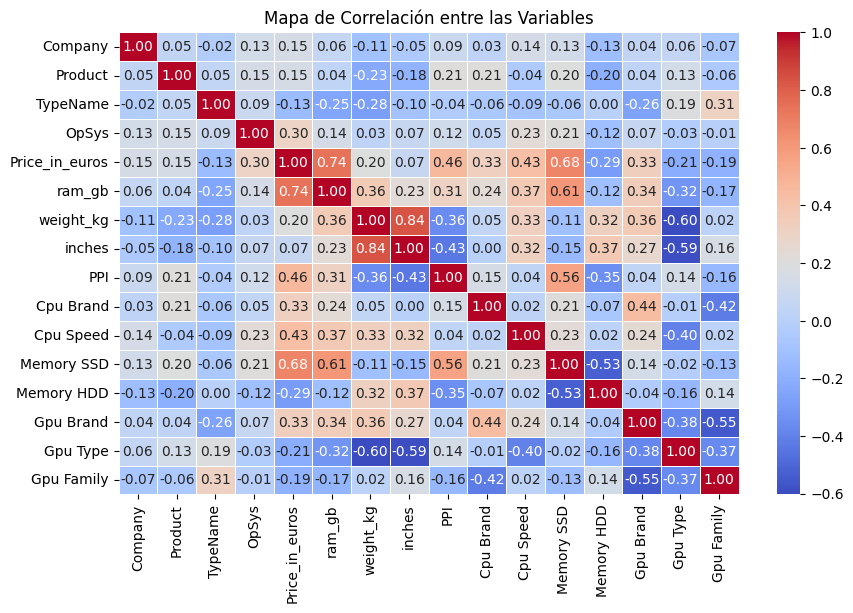

In [23]:
plt.figure(figsize=(10, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Mapa de Correlación entre las Variables")
plt.show()

-----------------------------------------------------------------------------------------------------------------

## Modelado

### 1. Definir X e y

In [24]:
X = df.drop(['Price_in_euros'], axis=1)
y = df['Price_in_euros'].copy()
X.shape

(912, 15)

In [25]:
X = df.iloc[:, df.columns != 'Price_in_euros'].copy()
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Company     912 non-null    float64
 1   Product     912 non-null    float64
 2   TypeName    912 non-null    float64
 3   OpSys       912 non-null    float64
 4   ram_gb      912 non-null    int64  
 5   weight_kg   912 non-null    float64
 6   inches      912 non-null    float64
 7   PPI         912 non-null    float64
 8   Cpu Brand   912 non-null    float64
 9   Cpu Speed   912 non-null    float64
 10  Memory SSD  912 non-null    int64  
 11  Memory HDD  912 non-null    int64  
 12  Gpu Brand   912 non-null    int64  
 13  Gpu Type    912 non-null    int64  
 14  Gpu Family  912 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 114.0 KB


In [26]:
y = df.iloc[:,4].copy()
y.info()

<class 'pandas.core.series.Series'>
Index: 912 entries, 755 to 229
Series name: Price_in_euros
Non-Null Count  Dtype  
--------------  -----  
912 non-null    float64
dtypes: float64(1)
memory usage: 14.2 KB


In [27]:
X.shape

(912, 15)

In [28]:
y.shape

(912,)

### 2. Dividir X_train, X_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [30]:
X_train

,Company,Product,TypeName,OpSys,ram_gb,weight_kg,inches,PPI,Cpu Brand,Cpu Speed,Memory SSD,Memory HDD,Gpu Brand,Gpu Type,Gpu Family
1118,7.0,462.0,5.0,7.0,8,3.00,17.3,127.335675,30.0,2.6,0,1000,0,0,4
153,4.0,187.0,1.0,5.0,16,2.56,15.6,141.211998,30.0,2.8,512,0,2,0,0
275,1.0,231.0,4.0,8.0,8,1.37,13.3,226.983005,29.0,2.9,512,0,1,1,2
1100,7.0,84.0,3.0,7.0,4,1.54,14.0,157.350512,29.0,2.3,0,500,1,1,1
131,4.0,190.0,3.0,5.0,16,2.80,17.3,127.335675,30.0,1.8,256,256,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
578,7.0,1.0,3.0,5.0,8,1.94,14.0,111.935204,32.0,1.6,0,2000,1,1,1
996,10.0,152.0,3.0,5.0,6,2.20,15.6,141.211998,3.0,3.6,256,0,0,0,6
770,4.0,215.0,4.0,5.0,16,1.18,12.5,176.232574,30.0,2.8,256,0,1,1,1
407,10.0,154.0,3.0,5.0,4,2.20,15.6,100.454670,25.0,1.1,0,1000,1,1,1


In [31]:
y_train

1118    2899.00
153     1249.26
275     1958.90
1100    1030.99
131     1396.00
         ...   
578      389.00
996      549.00
770     1859.00
407      306.00
418     1943.00
Name: Price_in_euros, Length: 729, dtype: float64

### 3. Baseline de modelos


In [32]:
RFmodel = RandomForestRegressor()
RFmodel.fit(X_train,y_train)
y_pred = RFmodel.predict(X_test)

In [33]:
lgbm = LGBMRegressor(random_state=42)
lgbm.fit(X_train, y_train)
y_pred_lgbm = lgbm.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 463
[LightGBM] [Info] Number of data points in the train set: 729, number of used features: 15
[LightGBM] [Info] Start training from score 1103.789314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

In [34]:
catboost = CatBoostRegressor(verbose=0, random_state=42)
catboost.fit(X_train, y_train)
y_pred_catboost = catboost.predict(X_test)

### 4. Sacar métricas, valorar los modelos 

Recuerda que en la competición se va a evaluar con la métrica de ``RMSE``.

In [35]:
RMSE = root_mean_squared_error(y_test,y_pred)
RMSE

338.80615839451264

In [36]:
rmse_lgbm = mean_squared_error(y_test, y_pred_lgbm) ** 0.5
rmse_lgbm

300.9794242192262

In [37]:
rmse_catboost = mean_squared_error(y_test, y_pred_catboost) ** 0.5
rmse_catboost

284.42283826981907

In [38]:
param_grid = {
    'depth': [6, 8, 10],         # Profundidad del árbol
    'learning_rate': [0.01, 0.05, 0.1],  # Tasa de aprendizaje
    'iterations': [500, 1000]    # Número de iteraciones
}

catboost = CatBoostRegressor(verbose=0, random_state=42)

# Optimización con GridSearchCV
grid_search = GridSearchCV(catboost, param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Mejor modelo encontrado
best_catboost = grid_search.best_estimator_

# Evaluar en el conjunto de prueba
y_pred_best = best_catboost.predict(X_test)
rmse_best = mean_squared_error(y_test, y_pred_best) ** 0.5

print(f"Mejor RMSE después de la optimización: {rmse_best}")


Mejor RMSE después de la optimización: 281.2012092767081


-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

### 1. Carga los datos de `test.csv` para predecir.


In [39]:
X_pred = pd.read_csv("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ONLINE_DS_THEBRIDGE_ALVAROSMMS/Sprint_13/Team Challenge/data/test.csv", index_col = 0)
X_pred.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
laptop_ID,,,,,,,,,,,
209,Lenovo,Legion Y520-15IKBN,Gaming,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD,Nvidia GeForce GTX 1060,No OS,2.4kg
1281,Acer,Aspire ES1-531,Notebook,15.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4GB,500GB HDD,Intel HD Graphics 400,Linux,2.4kg
1168,Lenovo,V110-15ISK (i3-6006U/4GB/1TB/No,Notebook,15.6,1366x768,Intel Core i3 6006U 2.0GHz,4GB,1TB HDD,Intel HD Graphics 520,No OS,1.9kg
1231,Dell,Inspiron 7579,2 in 1 Convertible,15.6,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,2.191kg
1020,HP,ProBook 640,Notebook,14.0,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,4GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.95kg


In [40]:
X_pred.index.name = None

In [41]:
X_pred.tail()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight
820,MSI,GE72MVR 7RG,Gaming,17.3,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16GB,512GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.9kg
948,Toshiba,Tecra Z40-C-12X,Notebook,14.0,IPS Panel Full HD 1920x1080,Intel Core i5 6200U 2.3GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.47kg
483,Dell,Precision M5520,Workstation,15.6,Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,8GB,256GB SSD,Nvidia Quadro M1200,Windows 10,1.78kg
1017,HP,Probook 440,Notebook,14.0,1366x768,Intel Core i5 7200U 2.5GHz,4GB,500GB HDD,Intel HD Graphics 620,Windows 10,1.64kg
421,Asus,ZenBook Flip,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows 10,1.27kg


In [42]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           391 non-null    object 
 1   Product           391 non-null    object 
 2   TypeName          391 non-null    object 
 3   Inches            391 non-null    float64
 4   ScreenResolution  391 non-null    object 
 5   Cpu               391 non-null    object 
 6   Ram               391 non-null    object 
 7   Memory            391 non-null    object 
 8   Gpu               391 non-null    object 
 9   OpSys             391 non-null    object 
 10  Weight            391 non-null    object 
dtypes: float64(1), object(10)
memory usage: 36.7+ KB


In [43]:
# Convertimos "Ram","Weight" y "Inches" a valores numéricos
X_pred['ram_gb'] = X_pred['Ram'].str.replace('GB', '').astype(int)
X_pred["weight_kg"] = X_pred['Weight'].str.replace('kg', '').astype(float)
X_pred["inches"] = X_pred.Inches.astype(float)

# Nos deshacemos de las columnas originales
X_pred.drop(columns=['Ram','Weight','Inches'], inplace=True)

In [44]:
# Resolución pantalla 
# Extraemos la resolución en píxeles
X_pred[['Res_X', 'Res_Y']] = X_pred['ScreenResolution'].str.extract(r'(\d+)x(\d+)').astype(float)

# Calculamos los píxeles por pulgadas 
X_pred['PPI'] = ((X_pred['Res_X']**2 + X_pred['Res_Y']**2) ** 0.5) / X_pred['inches']

# Nos deshacemos de las columnas Cpu Originales y creadas 
X_pred.drop(columns=['ScreenResolution','Res_X', 'Res_Y'], inplace=True)

In [45]:
# CPU
# Extraemos los valores de Cpu
X_pred['Cpu Brand'] = X_pred['Cpu'].apply(lambda x: " ".join(x.split()[:3]) if pd.notnull(x) else np.nan) # Tomamos las 3 primeras palabras [:3]

X_pred['Cpu Speed'] = X_pred['Cpu'].apply(lambda x: float(x.split()[-1][:-3]) if pd.notnull(x) else np.nan)  # Cogemos la última palabra [-1] y eliminamos los 3 últimos caracteres [:-3]
    
# Imputamos valores nulos en Cpu Speed con la mediana de la marca
cpu_median = X_pred.groupby('Cpu Brand')['Cpu Speed'].transform('median')
X_pred['Cpu Speed'] = X_pred['Cpu Speed'].fillna(cpu_median)

# Nos deshacemos de la columna Cpu Original  
X_pred.drop(columns=['Cpu'], inplace=True)

In [46]:
# Procesamos la memoria
# Reemplazamos "Flash Storage" por "SDD"
X_pred['Memory'] = X_pred['Memory'].str.replace('Flash Storage', 'SSD')

# Función para convertir los TB a GB
def extract_memory(x, storage_type):
    if storage_type in x:
        value, unit = x.split()[0][:-2], x.split()[0][-2:]  # Extraemos número y unidad (GB o TB)
        size = int(float(value) * 1000) if unit == 'TB' else int(float(value))  # Convertimos TB a GB si es necesario
        return size
    return 0

# Extraemos el tamaño en SSD
X_pred['Memory SSD'] = X_pred['Memory'].apply(lambda x: extract_memory(x, 'SSD') if pd.notnull(x) else np.nan)

# Extraemos el tamaño en HDD
X_pred['Memory HDD'] = X_pred['Memory'].apply(lambda x: extract_memory(x, 'HDD') if pd.notnull(x) else np.nan)

# Nos deshacemos de la columna original 
X_pred.drop(columns=['Memory'], inplace=True)

In [59]:
#  1-Extraer el fabricante (Intel, Nvidia o AMD)
X_pred['Gpu Brand'] = X_pred['Gpu'].apply(lambda x: 'Intel' if 'Intel' in x else ('Nvidia' if 'Nvidia' in x else 'AMD'))

#  2-Identificar si es integrada o dedicada
X_pred['Gpu Type'] = X_pred['Gpu'].apply(lambda x: 'Integrada' if 'Intel' in x or 'R2' in x or 'R4' in x else 'Dedicada')

#  3-Extraer la familia
X_pred['Gpu Family'] = X_pred['Gpu'].apply(lambda x: 'GTX' if 'GTX' in x else 
                                            ('MX' if 'MX' in x else 
                                             ('Quadro' if 'Quadro' in x else 
                                              ('Iris' if 'Iris' in x else 
                                               ('HD Graphics' if 'HD Graphics' in x else 
                                                ('Radeon' if 'Radeon' in x else 'Other'))))))

# 4-Convertir todo en variables numéricas
encoder = LabelEncoder()
X_pred['Gpu Brand'] = encoder.fit_transform(X_pred['Gpu Brand'])
X_pred['Gpu Type'] = encoder.fit_transform(X_pred['Gpu Type'])
X_pred['Gpu Family'] = encoder.fit_transform(X_pred['Gpu Family'])

X_pred.drop(columns=['Gpu'], inplace=True)

In [60]:
# Procesar características categóricas
categorical_features = ['Company','Product', 'TypeName', 'OpSys', 'Cpu Brand']
ordinal_encoder = OrdinalEncoder()
X_pred[categorical_features] = ordinal_encoder.fit_transform(X_pred[categorical_features])

In [61]:
X_pred.head()

,Company,Product,TypeName,OpSys,ram_gb,weight_kg,inches,PPI,Cpu Brand,Cpu Speed,Memory SSD,Memory HDD,Gpu Brand,Gpu Type,Gpu Family
209,9.0,134.0,1.0,3.0,16,2.400,15.6,141.211998,20.0,2.8,512,0,2,0,0
1281,0.0,37.0,3.0,1.0,4,2.400,15.6,100.454670,15.0,1.6,0,500,1,1,1
1168,9.0,222.0,3.0,3.0,4,1.900,15.6,100.454670,18.0,2.0,0,1000,1,1,1
1231,4.0,122.0,0.0,4.0,8,2.191,15.6,141.211998,19.0,2.5,256,0,1,1,1
1020,7.0,159.0,3.0,4.0,4,1.950,14.0,157.350512,19.0,2.5,256,0,1,1,1


In [62]:
X_pred.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391 entries, 209 to 421
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Company     391 non-null    float64
 1   Product     391 non-null    float64
 2   TypeName    391 non-null    float64
 3   OpSys       391 non-null    float64
 4   ram_gb      391 non-null    int64  
 5   weight_kg   391 non-null    float64
 6   inches      391 non-null    float64
 7   PPI         391 non-null    float64
 8   Cpu Brand   391 non-null    float64
 9   Cpu Speed   391 non-null    float64
 10  Memory SSD  391 non-null    int64  
 11  Memory HDD  391 non-null    int64  
 12  Gpu Brand   391 non-null    int64  
 13  Gpu Type    391 non-null    int64  
 14  Gpu Family  391 non-null    int64  
dtypes: float64(9), int64(6)
memory usage: 48.9 KB


In [63]:
X_pred= X_pred.iloc[:,  X_pred.columns != 'Price_in_euros'].copy()

 ## 2. Replicar el procesado para ``test.csv``

In [64]:
X_pred

,Company,Product,TypeName,OpSys,ram_gb,weight_kg,inches,PPI,Cpu Brand,Cpu Speed,Memory SSD,Memory HDD,Gpu Brand,Gpu Type,Gpu Family
209,9.0,134.0,1.0,3.0,16,2.400,15.6,141.211998,20.0,2.8,512,0,2,0,0
1281,0.0,37.0,3.0,1.0,4,2.400,15.6,100.454670,15.0,1.6,0,500,1,1,1
1168,9.0,222.0,3.0,3.0,4,1.900,15.6,100.454670,18.0,2.0,0,1000,1,1,1
1231,4.0,122.0,0.0,4.0,8,2.191,15.6,141.211998,19.0,2.5,256,0,1,1,1
1020,7.0,159.0,3.0,4.0,4,1.950,14.0,157.350512,19.0,2.5,256,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
820,10.0,64.0,1.0,4.0,16,2.900,17.3,127.335675,20.0,2.8,512,512,2,0,0
948,15.0,188.0,3.0,4.0,4,1.470,14.0,157.350512,19.0,2.3,128,0,1,1,1
483,4.0,153.0,5.0,4.0,8,1.780,15.6,141.211998,20.0,2.8,256,0,2,0,5
1017,7.0,162.0,3.0,4.0,4,1.640,14.0,111.935204,19.0,2.5,0,500,1,1,1


In [65]:
predictions_submit = best_catboost.predict(X_pred)
predictions_submit

array([1360.65257362,  266.862825  ,  319.37204419,  606.12191842,
        391.44522786,  524.37095397,  478.17347448,  638.6528297 ,
       1038.33725764,  263.77722165, 2043.87344477, 1128.48796679,
        351.54412643, 1554.48151675,  593.87582905,  452.26958897,
       1836.4313584 , 1184.83455354, 1360.32357091,  310.29957642,
        989.20713732,  328.38181215,  463.18770494,  895.04980624,
        321.08808289,  446.76378806,  403.58509758,  792.87231267,
       1811.11804533,  691.55045222, 1708.37983149,  237.04574527,
        446.55728894, 2299.10391737, 1893.15871661, 1772.23003653,
        395.46381856, 1028.57574727,  568.93125707, 1131.69737402,
        372.3856571 ,  902.58353906,  376.88846774,  962.27651436,
       1010.15536492,  712.43499941,  681.12139565,  302.70840863,
        668.87028633,  613.9113225 , 1492.35707928,  421.33756387,
        895.71666197,  263.61927838, 1036.46035075, 1156.76224401,
        386.15347258,  523.67594383,  579.78975806,  537.39979

**¡OJO! ¿Por qué me da error?** 

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

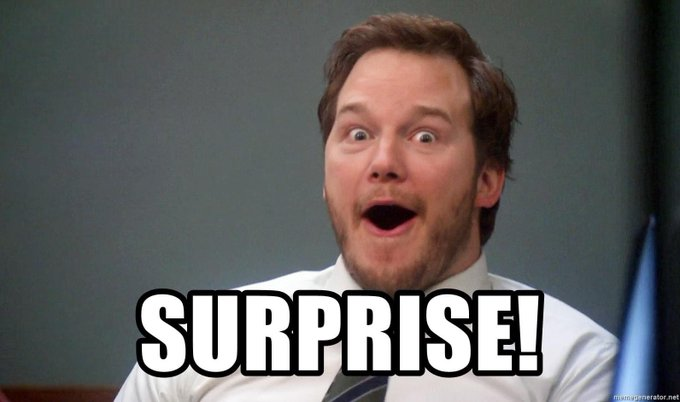

### 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`. 

In [66]:
sample = pd.read_csv("data/sample_submission.csv")

In [67]:
sample.head()

,laptop_ID,Price_in_euros
0,209,1949.1
1,1281,805.0
2,1168,1101.0
3,1231,1293.8
4,1020,1832.6


In [68]:
sample.shape

(391, 2)

### 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [69]:
#¿Cómo creamos la submission?
submission = pd.DataFrame({"laptop_ID": X_pred.index,"Price_in_euros":predictions_submit})

In [70]:
submission.head()

,laptop_ID,Price_in_euros
0,209,1360.652574
1,1281,266.862825
2,1168,319.372044
3,1231,606.121918
4,1020,391.445228


In [71]:
submission.shape

(391, 2)

### 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [72]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [73]:
chequeador(submission)

You're ready to submit!
